In [1]:
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

#Library untuk tahap Modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

#Library untuk menggunakan algoritma Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import resample

In [2]:
df_AllApp_Labeled = pd.read_csv(r"C:\Latihan_Python\casptone-project-dicoding_nihongonavigator\AllAppRev_Labeled.csv")

In [3]:
# Langkah 1: Cek distribusi label
print("Distribusi awal:")
print(df_AllApp_Labeled['polarity'].value_counts())

# Langkah 2: Pisahkan data berdasarkan label
df_AllApp_Labeled_positive = df_AllApp_Labeled[df_AllApp_Labeled['polarity'] == 'positive']
df_AllApp_Labeled_neutral  = df_AllApp_Labeled[df_AllApp_Labeled['polarity'] == 'neutral']
df_AllApp_Labeled_negative = df_AllApp_Labeled[df_AllApp_Labeled['polarity'] == 'negative']

# Langkah 3: Oversample yang minoritas (neutral dan negative) hingga sama banyak dengan positive
df_AllApp_Labeled_neutral_upsampled = resample(df_AllApp_Labeled_neutral,
                                replace=True,
                                n_samples=len(df_AllApp_Labeled_positive),
                                random_state=42)

df_AllApp_Labeled_negative_upsampled = resample(df_AllApp_Labeled_negative,
                                 replace=True,
                                 n_samples=len(df_AllApp_Labeled_positive),
                                 random_state=42)

# Langkah 4: Gabungkan semua
df_AllApp_Labeled_balanced = pd.concat([df_AllApp_Labeled_positive, df_AllApp_Labeled_neutral_upsampled, df_AllApp_Labeled_negative_upsampled])

# Langkah 5: Shuffle
df_AllApp_Labeled_balanced = df_AllApp_Labeled_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Cek hasil balancing
print("\nDistribusi setelah balancing:")
print(df_AllApp_Labeled_balanced['polarity'].value_counts())

# -----------------------
# 2. Tokenizer & Padding
# -----------------------

MAX_LEN = 200  # atau sesuai panjang rata-rata teks

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_AllApp_Labeled_balanced['text_final_stemmed'])

sequences = tokenizer.texts_to_sequences(df_AllApp_Labeled_balanced['text_final_stemmed'])
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# -----------------------
# 3. Encode Label
# -----------------------

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df_AllApp_Labeled_balanced['polarity'])  # 0, 1, 2

# Ubah ke one-hot encoding
labels_onehot = to_categorical(labels)



Distribusi awal:
polarity
positive    6521
neutral     1015
negative      34
Name: count, dtype: int64

Distribusi setelah balancing:
polarity
negative    6521
neutral     6521
positive    6521
Name: count, dtype: int64


In [4]:
# -----------------------
# Train-Test Split
# -----------------------

X_train, X_test, y_train, y_test = train_test_split(
    padded, labels_onehot, test_size=0.2, random_state=42, stratify=labels
)

print(f"\nJumlah data latih: {len(X_train)} | data uji: {len(X_test)}")


Jumlah data latih: 15650 | data uji: 3913


In [5]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=MAX_LEN))  # MAX_LEN dari pipeline tadi
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # jumlah kelas = dimensi one-hot

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

c:\Users\User\virtual_env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Custom callback: Berhenti kalau akurasi training dan val > 98%
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.98 and logs.get('val_accuracy') > 0.98:
            print("\n🚨 Akurasi training dan validasi >98%! Pelatihan dihentikan.")
            self.model.stop_training = True

# Early stopping: stop jika val_loss tidak membaik dalam 5 epoch
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,  # Optional, agar bobot terbaik diambil
    verbose=1
)

# Simpan model terbaik berdasarkan val_accuracy
checkpoint = ModelCheckpoint(
    'best_model_lstm.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


# Gabungkan semua callbacks
callbacks = [early_stop, checkpoint, myCallback()]

In [8]:
# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7939 - loss: 0.5174
Epoch 1: val_accuracy improved from -inf to 0.98441, saving model to best_model_lstm.h5


245/245 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.7944 - loss: 0.5163 - val_accuracy: 0.9844 - val_loss: 0.0474
Epoch 2/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.9869 - loss: 0.0510
Epoch 2: val_accuracy did not improve from 0.98441
245/245 ━━━━━━━━━━━━━━━━━━━━ 232s 947ms/step - accuracy: 0.9869 - loss: 0.0514 - val_accuracy: 0.9767 - val_loss: 0.0892
Epoch 3/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9847 - loss: 0.0521
Epoch 3: val_accuracy improved from 0.98441 to 0.99233, saving model to best_model_lstm.h5



🚨 Akurasi training dan validasi >98%! Pelatihan dihentikan.
245/245 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.9847 - loss: 0.0522 - val_accuracy: 0.9923 - val_loss: 0.0294
Restoring model weights from the end of the best epoch: 3.


In [9]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Akurasi pada data test:", accuracy)

Akurasi pada data test: 0.9923332333564758


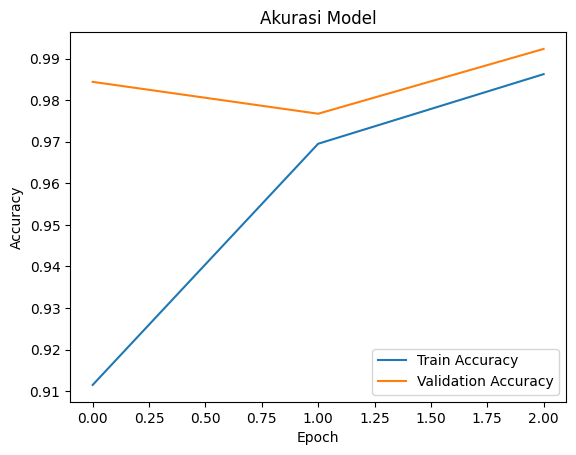

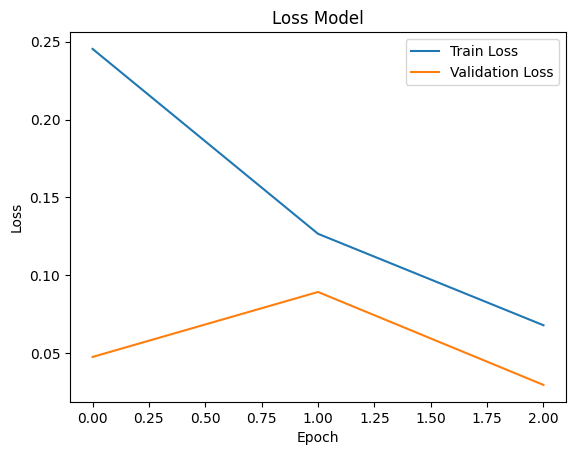

In [11]:
# Plot akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


123/123 ━━━━━━━━━━━━━━━━━━━━ 22s 168ms/step


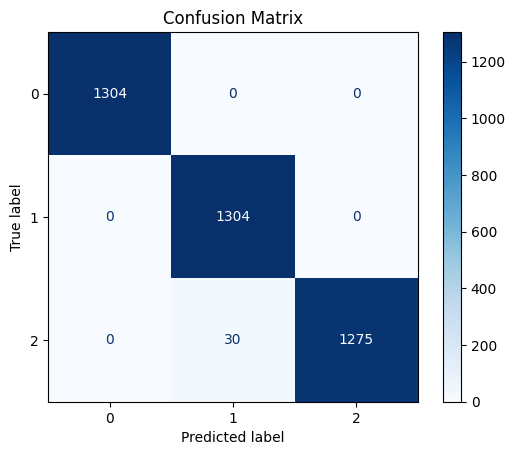

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1304
           1       0.98      1.00      0.99      1304
           2       1.00      0.98      0.99      1305

    accuracy                           0.99      3913
   macro avg       0.99      0.99      0.99      3913
weighted avg       0.99      0.99      0.99      3913



In [12]:

# Prediksi pada data uji
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)  # untuk multi-class softmax
y_true = y_test.argmax(axis=1)

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Optional: laporan klasifikasi
print(classification_report(y_true, y_pred_classes))


In [13]:
# Simpan model (sudah ada jika pakai ModelCheckpoint)
# model.save('model_lstm_final.h5')

# Simpan tokenizer
with open('tokenizer_lstm.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Simpan label encoder (jika diperlukan)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)


Inferensi

In [14]:
import re
import string
import nltk
nltk.data.path.append(r"C:\Users\User\AppData\Roaming\nltk_data")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
nltk.download('stopwords')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka
    text = re.sub(r'[^A-Za-z\s]', '', text)


    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy", "wkwk", "uuu"])
    important_words = {'baik', 'buruk', 'mantap', 'bagus', 'jelek', 'mudah', 'cepat', 'nyaman'} #Bisa ditambah
    # Hapus kata penting dari daftar stopwords
    listStopwords = listStopwords - important_words

    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [16]:
def load_slang_dictionary():
    slangwords = {}

    def read_file(path, delimiter):
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if delimiter not in line or not line:
                    continue  # lewati baris yang kosong atau tidak valid
                parts = line.split(delimiter, 1)
                if len(parts) != 2:
                    continue  # lewati jika tetap gagal dibagi jadi 2
                key, value = parts
                if key and value:
                    slangwords[key.lower()] = value.lower()

    # Gabungkan dari semua file
    read_file(r'C:\Latihan_Python\@-proyek-course-dicoding\proyek_analisis_sentimen\Indonesian Slang dictionary (from github)\formalizationDict.txt', '\t')
    read_file(r'C:\Latihan_Python\@-proyek-course-dicoding\proyek_analisis_sentimen\Indonesian Slang dictionary (from github)\kbba.txt', '\t')
    read_file(r'C:\Latihan_Python\@-proyek-course-dicoding\proyek_analisis_sentimen\Indonesian Slang dictionary (from github)\slangword.txt', ':')

    return slangwords

# Panggil fungsi
slangwords = load_slang_dictionary()

# Contoh tampilkan 10 kata
for i, (k, v) in enumerate(slangwords.items()):
    if i >= 10: break
    print(f"{k} -> {v}")

def fix_slangwords(text, slang_dict):
    words = text.split()  # Memecah teks jadi list kata
    fixed_words = [slang_dict.get(word.lower(), word) for word in words]  # Ganti jika ada di kamus
    return ' '.join(fixed_words)  # Gabung kembali jadi kalimat

7an -> tujuan
@ -> di
ababil -> anak ingusan
abis -> habis
acc -> accord
ad -> ada
adlah -> adalah
adlh -> adalah
adoh -> aduh
afaik -> as far as i know


In [17]:
def split_heuristic(text):
    # Ganti koma dan kata penghubung umum dengan titik
    text = re.sub(r'\s*(,|namun|tapi|tetapi|meskipun|walaupun|serta)\s*', '.', text)
    
    # Pisah berdasarkan titik atau baris baru
    sentences = re.split(r'\.|\n', text)

    # Bersihkan hasil
    sentences = [s.strip() for s in sentences if len(s.strip()) > 3]

    return sentences


In [19]:
def normalize_tokens(tokens, norm_dict):
    return [norm_dict.get(word, word) for word in tokens]

In [18]:
custom_normalization = {
    "mantaaap": "mantap",
    "bangett": "banget",
    "kerenn": "keren",
    "prem": "premium",
    "bagusss": "bagus",
    "membantuuu": "membantu",
    "bangettt": "banget",
    "bingunggg": "bingung",
    "sangattt": "sangat",
    "waaaah": "wah",
    "polll": "pol",           
    "tulisannnya": "tulisannya",
    "maziiini": "mazii ini",
    "salahhadehhhh": "salah hadeh",
    "sangaatttt": "sangat",
    "lagiii": "lagi",
    "bagusssss": "bagus",
    "bagusssbisa": "bagus bisa",
    "mantaaapberjamjam": "mantap berjam-jam",
    "waaaaah": "wah",
    "yaaa": "ya",
    "mmmmungkin": "mungkin",
    "bagussss": "bagus",
    "mantappppuuu": "mantap",
    "majuuu": "maju",
    "bagussssss": "bagus",
    "akuuu": "aku",
    "hehheee": "hehe",
    "kerennnn": "keren",
    "makasiii": "makasih",
    "gimanasi": "bagaimana sih",
    "arigato": "terima kasih",
    "arigatou": "terima kasih",
    "radical": "radikal",
    "knji": "kanji",
    "knj": "kanji",
}


In [26]:
def predict_dl(text):
    text_clean = stemmingText(toSentence(filteringText(normalize_tokens(tokenizingText(fix_slangwords(toSentence(split_heuristic(casefoldingText(cleaningText(text)))), slangwords)), custom_normalization))))
    seq = tokenizer.texts_to_sequences([text_clean])
    pad = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')
    pred = model.predict(pad)
    label_index = pred.argmax()
    return label_encoder.inverse_transform([label_index])[0]


predict_dl("App-nya keren banget! grafik mantap dan seru, bisa belajar kanji bunpo dll dengan gampang!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


'positive'

In [24]:
def predict_dl(text):
    text_clean = stemmingText(toSentence(filteringText(normalize_tokens(tokenizingText(fix_slangwords(toSentence(split_heuristic(casefoldingText(cleaningText(text)))), slangwords)), custom_normalization))))
    seq = tokenizer.texts_to_sequences([text_clean])
    pad = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')
    pred = model.predict(pad)
    label_index = pred.argmax()
    return label_encoder.inverse_transform([label_index])[0]


predict_dl("Mungkin bisa update optimalisasinya")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


'neutral'

In [25]:
def predict_dl(text):
    text_clean = stemmingText(toSentence(filteringText(normalize_tokens(tokenizingText(fix_slangwords(toSentence(split_heuristic(casefoldingText(cleaningText(text)))), slangwords)), custom_normalization))))
    seq = tokenizer.texts_to_sequences([text_clean])
    pad = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')
    pred = model.predict(pad)
    label_index = pred.argmax()
    return label_encoder.inverse_transform([label_index])[0]


predict_dl("Sering bug, grafik burik, lag, berat, dan bikin HP panas, tolong perbaiki!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


'negative'